In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-05-13 11:03:52.706275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/train/")
count = 0
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        for file in os.listdir(directory+folder+back+subfolder):
            file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
            if 'filtered.npy' in file_directory:
                data.append(np.load(str(file_directory)))
                count += 1

b'HIP44295-23'
b'HIP63503-523'
b'AND_XI-2274'
b'HIP36393-1253'
b'HIP48477-589'


(666733, 16, 256)


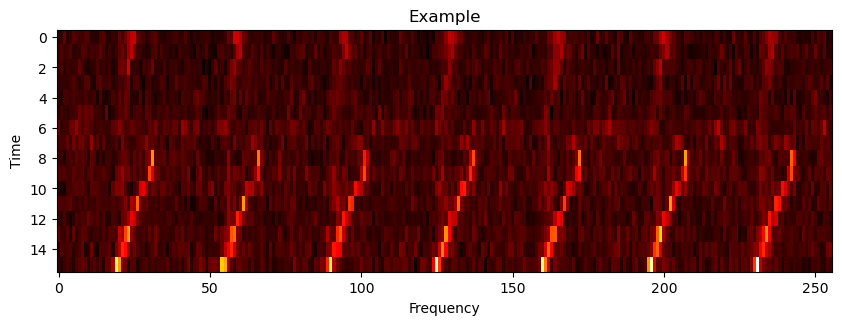

In [3]:
import numpy as np
data = np.vstack(data)
print(data.shape)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [4]:
from tqdm import tqdm

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

data = np.expand_dims(normalize_data(data), axis = -1)
print(data[0,:,:].max(), data[0,:,:].min())

100%|████████████████████████████████| 666733/666733 [01:00<00:00, 10951.85it/s]

1.0 0.0


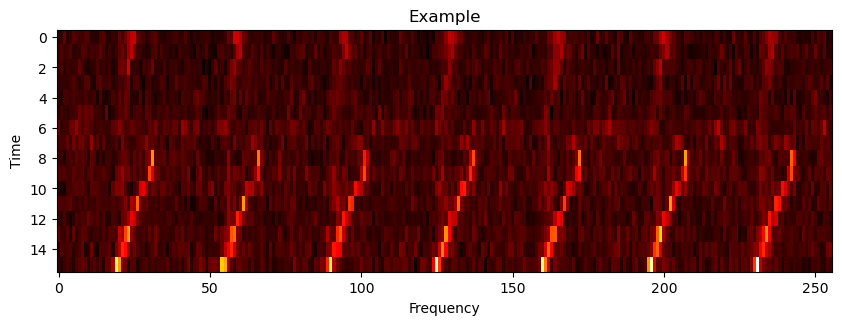

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.33, random_state=42)

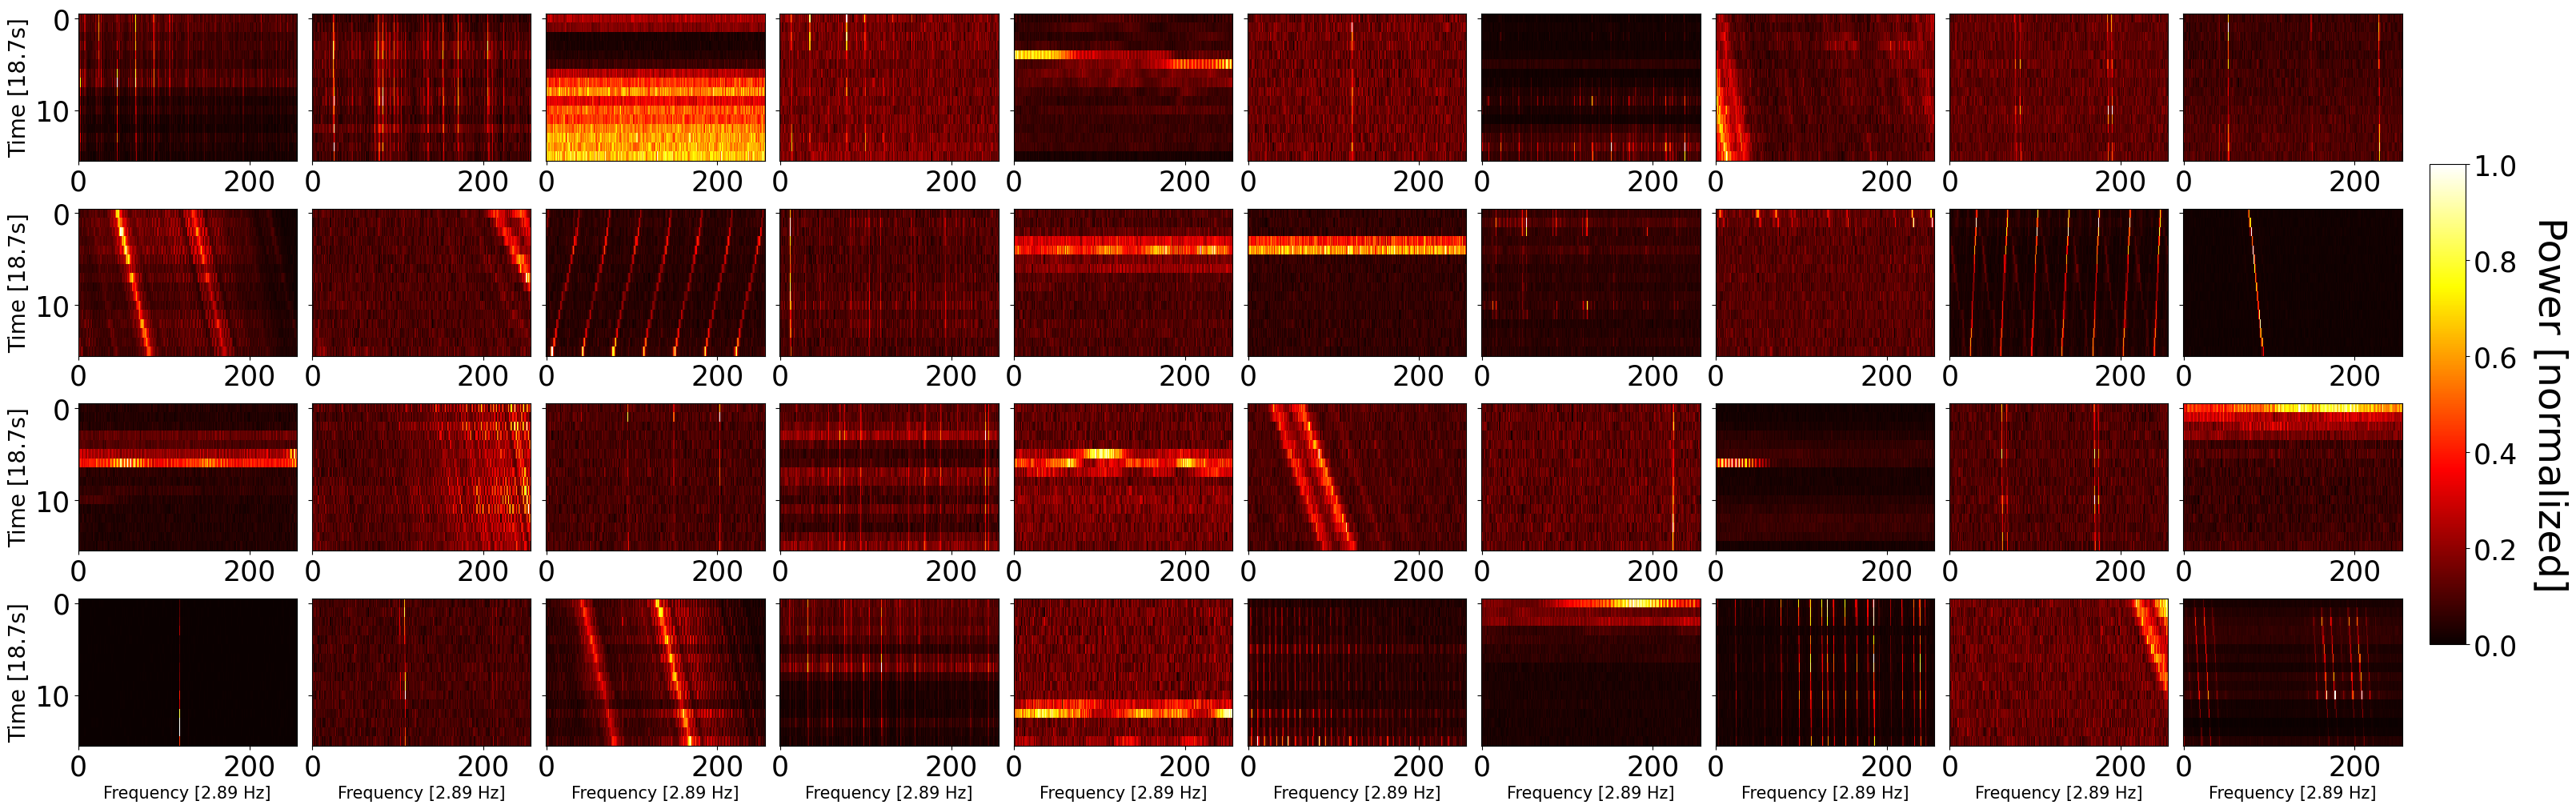

In [7]:
ind = np.random.randint(0, X_train.shape[0], size=(10, 10))
font_size = 25
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(4, 10, sharey=True, figsize=(30, 10), constrained_layout=True)

for j in range(10):
    for i in range(4):
        inde = ind[i, j]
        im = ax[i,j].imshow(X_train[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
        if i == 3:
            ax[i,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-10)  
        if j ==0:
            ax[i,j].set_ylabel("Time [18.7s]",  fontsize=font_size-5)  
                  
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/training_examples.pdf", format="pdf")


In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = 4
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(
            name="kl_loss"
        )
        self.kl_additional = tf.keras.losses.KLDivergence()
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]
    def gaussanity_loss(self, data, base):
        return self.kl_additional(data, base)
    
    def train_step(self, data_in):
        data = data_in
        print(data.shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            
            total_loss = reconstruction_loss + self.beta * kl_loss
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    def test_step(self, data_in):
        data, _ = data_in
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        total_loss = reconstruction_loss + self.beta * kl_loss 
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "test_loss": self.total_loss_tracker.result(),
            "test_kl_loss": self.kl_loss_tracker.result(),
            "test_reconstruction_loss": self.reconstruction_loss_tracker.result()
        }

# Encoder Model

In [10]:
latent_dim = 8
time_samples = X_train.shape[1]
freq_sample =  X_train.shape[2]
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)


z_mean = layers.Dense(64, activation="relu")(x)
z_mean = layers.BatchNormalization()(z_mean)
z_mean = layers.Dense(latent_dim, name="z_mean")(z_mean)

z_log_var = layers.Dense(64, activation="relu")(x)
z_log_var = layers.BatchNormalization()(z_log_var)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(z_log_var)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 16, 256, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 128, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 128, 16)  64         ['max_pooling2d[0][0]']    

2023-05-13 11:05:14.966421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 11:05:16.320007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14233 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-05-13 11:05:16.320677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14233 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:61:00.0, compute capability: 8.6
2023-05-13 11:05:16.321135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

# Decoder Model

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_4 (Dense)             (None, 128)               1152      
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 4096)              528384    
                                                                 
 batch_normalization_10 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 reshape (Reshape)           (None, 16, 8, 32)         0   

# Training Model

In [12]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_test_reconstruction_loss', mode='min', verbose=1, patience=10)
print(X_train.shape)
autoencoder = VAE(encoder, decoder)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-4))
history = autoencoder.fit(X_train, validation_data = (X_test[:20_000,:,:,:],X_test[:20_000,:,:,:]),
                  epochs=200, batch_size = 128, callbacks=[es])

(446711, 16, 256, 1)
Epoch 1/200
(None, 16, 256, 1)
(None, 16, 256, 1)


2023-05-13 11:05:26.461584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-13 11:05:28.076961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-13 11:05:28.682618: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f05905eee60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-13 11:05:28.682686: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-05-13 11:05:28.682694: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A4000, Compute Capability 8.6
2023-05-13 11:05:28.682703: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA RTX A4000, Compute Capability 8.6
2023-05-13 11:05:28.682709: I tensorflow/compiler/xla/service/

3490/3490 [==============================] - 121s 31ms/step - loss: 1437.9271 - kl_loss: 1.2103 - reconstruction_loss: 26.2866 - val_test_loss: 1248.0378 - val_test_kl_loss: 1.6227 - val_test_reconstruction_loss: 17.6112
Epoch 2/200
3490/3490 [==============================] - 108s 31ms/step - loss: 1244.1071 - kl_loss: 1.6862 - reconstruction_loss: 16.8514 - val_test_loss: 1243.3273 - val_test_kl_loss: 1.7187 - val_test_reconstruction_loss: 16.4476
Epoch 3/200
3490/3490 [==============================] - 107s 31ms/step - loss: 1242.1568 - kl_loss: 1.7251 - reconstruction_loss: 16.2652 - val_test_loss: 1241.6893 - val_test_kl_loss: 1.7274 - val_test_reconstruction_loss: 16.0860
Epoch 4/200
3490/3490 [==============================] - 107s 31ms/step - loss: 1240.5637 - kl_loss: 1.7256 - reconstruction_loss: 15.9763 - val_test_loss: 1240.7737 - val_test_kl_loss: 1.7228 - val_test_reconstruction_loss: 15.8654
Epoch 5/200
3490/3490 [==============================] - 108s 31ms/step - loss: 

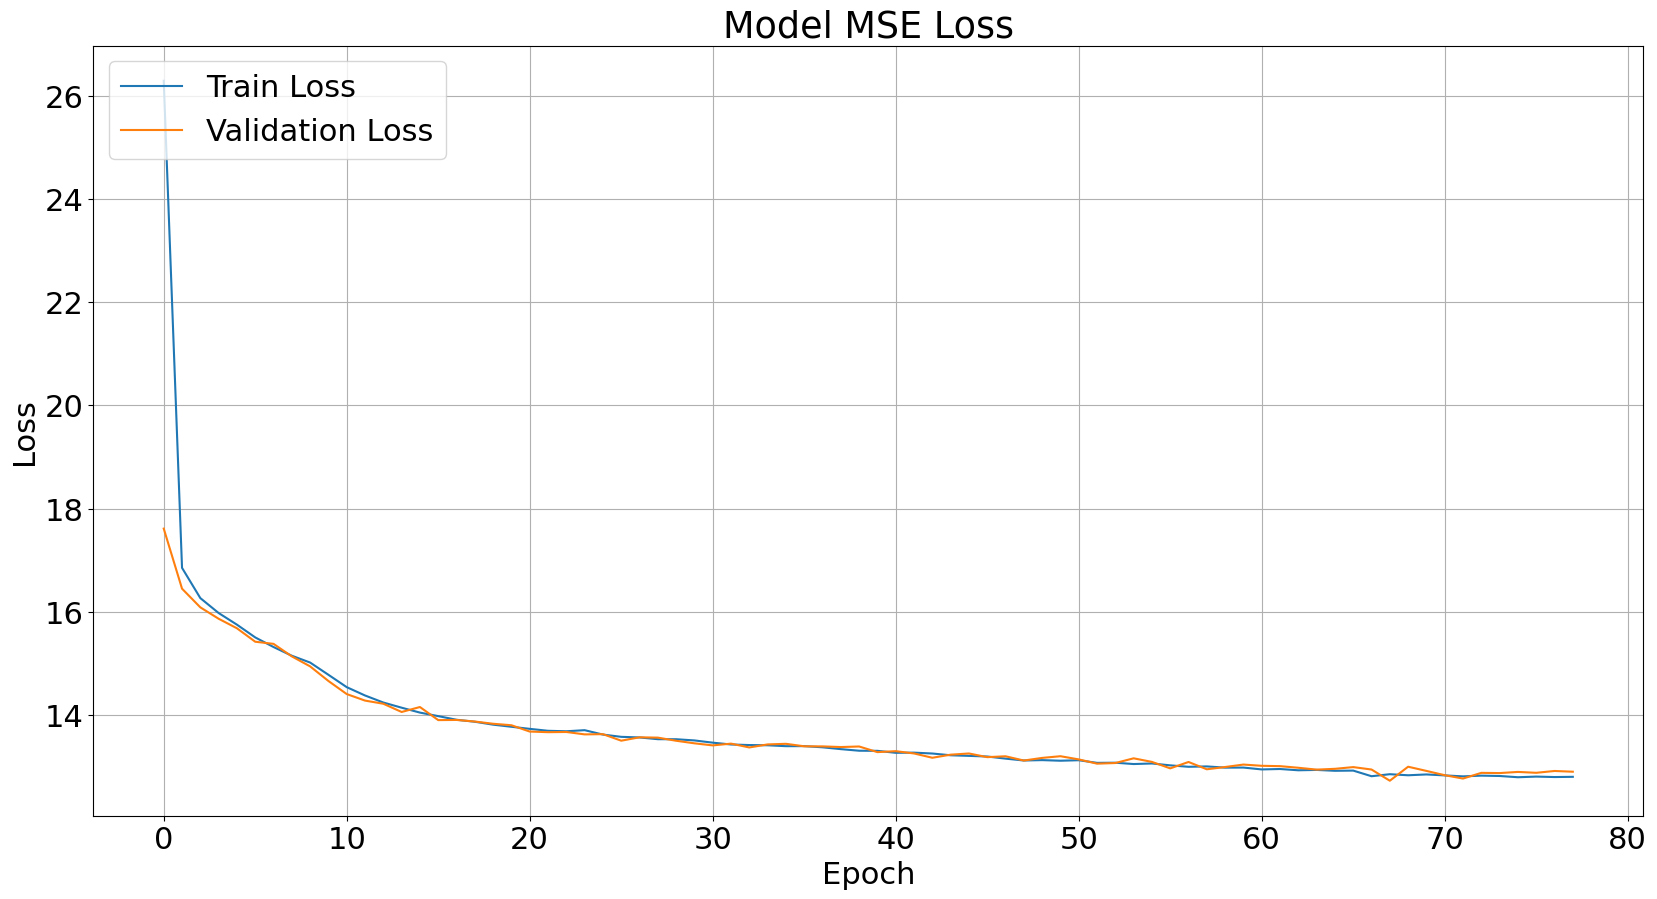

In [13]:
import pandas as pd
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_test_reconstruction_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
# plt.yscale('log')
plt.grid()
plt.savefig("plots/training_loss.pdf", format='pdf')
plt.show()

training_history = {}
training_history['train'] = history.history['reconstruction_loss']
training_history['test'] = history.history['val_test_reconstruction_loss']
df = pd.DataFrame(training_history)
df.to_csv("plots/training_loss.csv")

In [14]:
from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
idtag = date_time.replace(', ','-').replace('/','-').replace(':','-')
print(idtag)

autoencoder.save_weights("models/full-weights-"+idtag, save_format="tf")

05-13-2023-13-25-27


In [15]:
# autoencoder.load_weights("models/full-weights-"+idtag)
# autoencoder.compile(optimizer=keras.optimizers.Adam(lr = 1e-4), run_eagerly=True)

# Test Reconstruction

1/1 [==============================] - 0s 14ms/step
(1, 16, 256, 1)


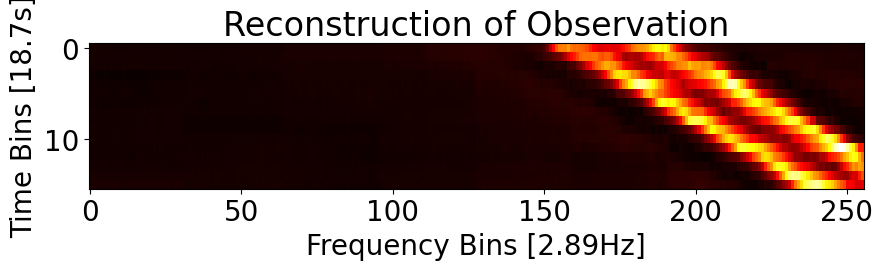

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 12

beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[index:index+1,:,:,:])[-1])
print(beam_reconstruction.shape)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Reconstruction of Observation")
plt.imshow(beam_reconstruction[0,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.7s]")
plt.xlabel("Frequency Bins [2.89Hz]")
plt.savefig("plots/reconstruction.pdf", format='pdf')

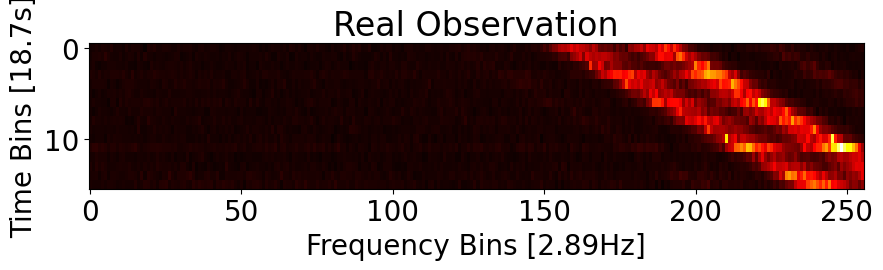

In [17]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Real Observation")
plt.imshow(X_test[index,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.7s]")
plt.xlabel("Frequency Bins [2.89Hz]")
plt.savefig("plots/real.pdf", format='pdf')

1/1 [==============================] - 0s 20ms/step


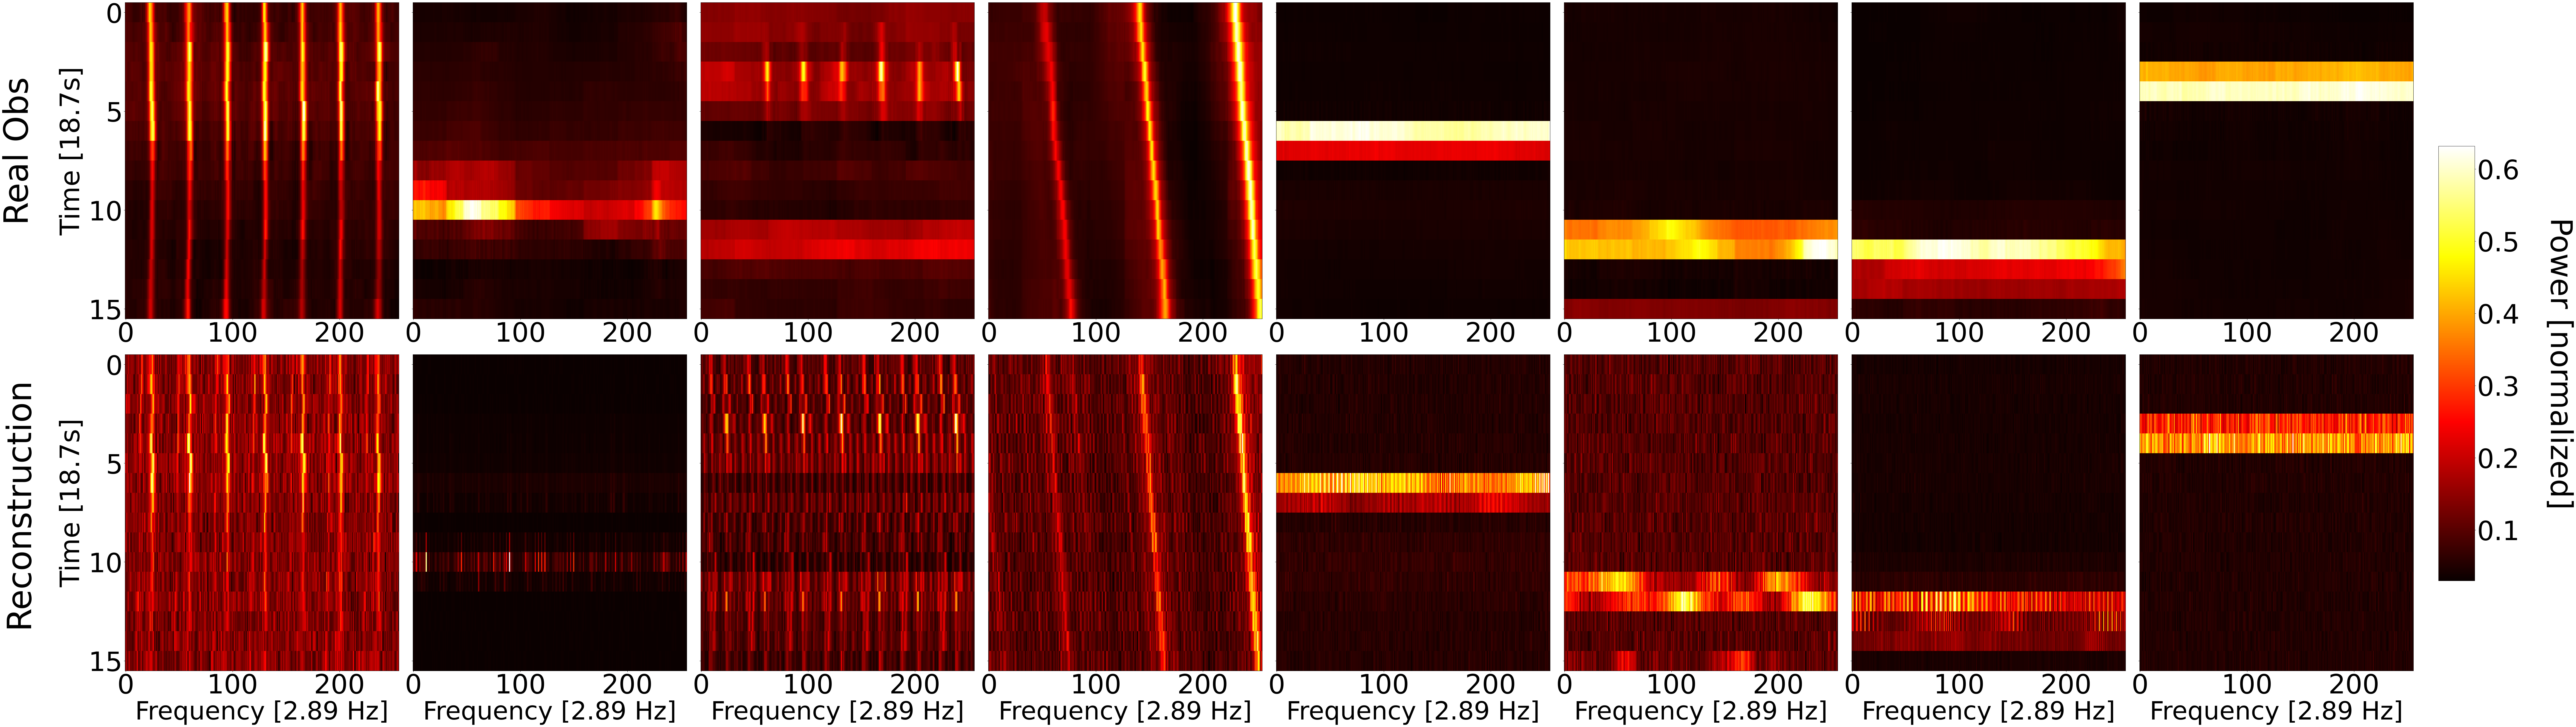

In [24]:
ind = np.random.randint(20_000, X_test.shape[0], size=(10))
font_size = 80
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(2, 8, sharey=True, figsize=(100, 30), constrained_layout=True)

for j in range(8):
    inde = ind[j]
    beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[inde:inde+1,:,:,:])[-1])
    im = ax[0,j].imshow(beam_reconstruction[0,:,:,0], cmap='hot',
                        interpolation='nearest', aspect="auto")
    ax[1,j].imshow(X_test[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
    if j == 0:
        ax[1,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
        ax[1,j].text(-100, 7, 'Reconstruction', ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
        ax[0,j].text(-100, 7, 'Real Obs', ha='center', va='center', rotation='vertical',  fontsize=font_size  +20)
        ax[0,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
    ax[1,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-5)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/reconstruction_test.pdf", format="pdf")

# Preturb Axis

In [46]:
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
index = 12
rows = 10
rate = 0.5
total_images = []
vec = autoencoder.encoder.predict(X_test[index:index+1,:,:,:])[0]

for i in range(latent_dim):
    sub_images = []
    perturb = []
    for k in range(rows):
        new_vec = deepcopy(vec)
        perturb.append(rate*k-rate)
        new_vec[0,i] += rate*k-rate
        image = autoencoder.decoder(new_vec)
        sub_images.append(image)
    total_images.append(sub_images)
    
f, ax = plt.subplots(rows, latent_dim, sharey=True, figsize=(100, 100), constrained_layout=True)

for j in range(latent_dim):
    ax[0,j].set_title("$z_{index}$".format(index=j), fontsize=font_size+100 )
    for t in range(rows):
        inde = ind[j]
        im = ax[t,j].imshow(total_images[j][t][0,:,:,0], cmap='hot',
                            interpolation='nearest', aspect="auto")
        if j == 0:
            ax[t,j].text(-100, 7, str(perturb[t]), ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
            ax[t,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
        ax[rows-1,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-5)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/perturb.pdf", format="pdf")

1/1 [==============================] - 0s 23ms/step


# Test Scores

In [47]:
import numpy as np
import setigen as stg
from blimpy import Waterfall
import matplotlib.pyplot as plt
import random
import os
from astropy import units as u
from tqdm import tqdm
num_classes = 100
num_samples_per_class = 1000


In [60]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/test/")
count = 0
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        for file in os.listdir(directory+folder+back+subfolder):
            file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
            if 'filtered.npy' in file_directory:
                data.append(np.load(str(file_directory)))
                count += 1
data = np.vstack(data)
print(data.shape)

b'HIP104887-1850'
b'HIP87579-1008'
(347064, 16, 256)


In [61]:
def painting(data):
    all_data = []
    labels = []
    for c in tqdm(range(num_classes)):
        drift = 2*random.random()*(-1)**random.randint(0,2)
        snr = random.randint(100, 150)
        width = random.randint(20, 50)
        for s in range(num_samples_per_class):
            index = random.randint(0, data.shape[0]-1)
            window = data[index, :,:]
            
            start = random.randint(50, 180)
            
            frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                                        dt=18.253611008*u.s,
                                        fch1=1289*u.MHz,
                                        ascending=True,
                                        data=window)
            frame.add_signal(stg.constant_path(
                                        f_start=frame.get_frequency(index=start),
                                       drift_rate=drift*u.Hz/u.s),
                                      stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
                                      stg.gaussian_f_profile(width=width*u.Hz),
                                      stg.constant_bp_profile(level=1))
            all_data.append(frame.data)
            labels.append(c)
    all_data = np.array(all_data)
    labels = np.vstack(labels)
    return all_data, labels

In [62]:
injected, labels = painting(data)

100%|█████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


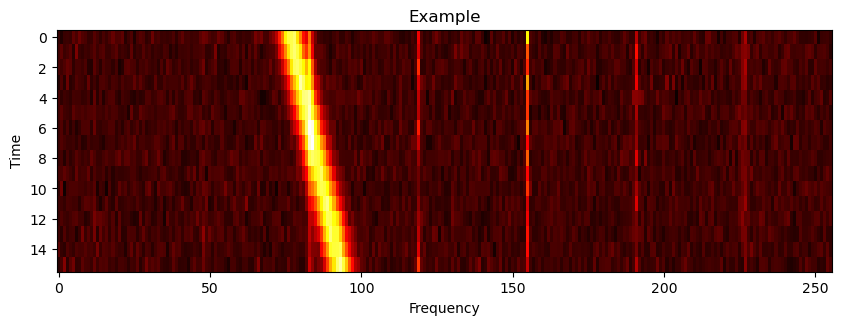

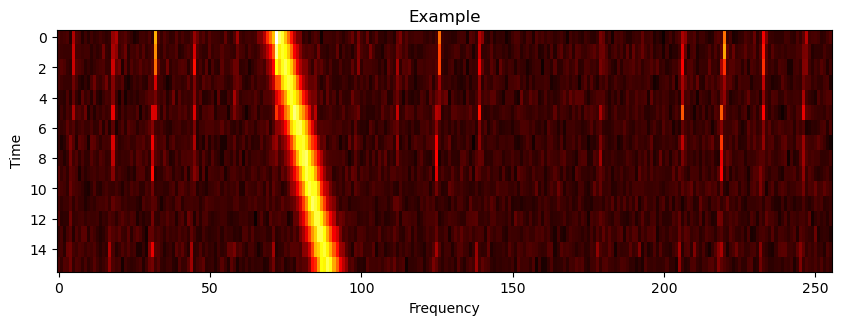

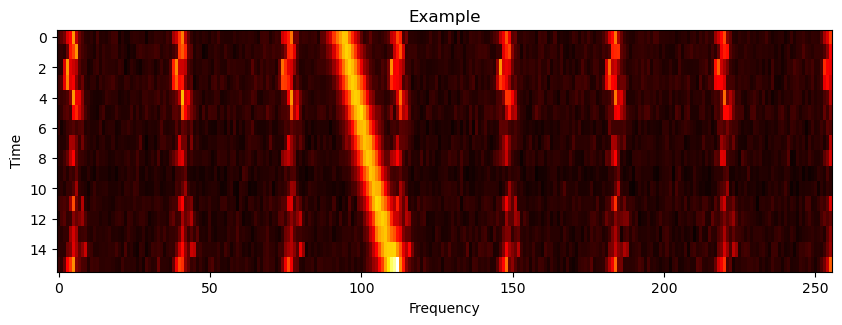

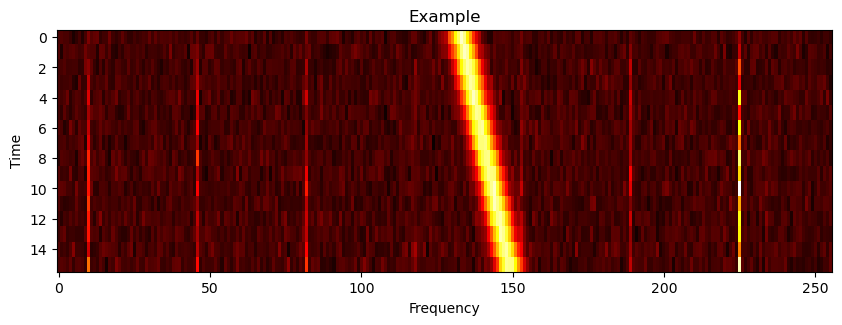

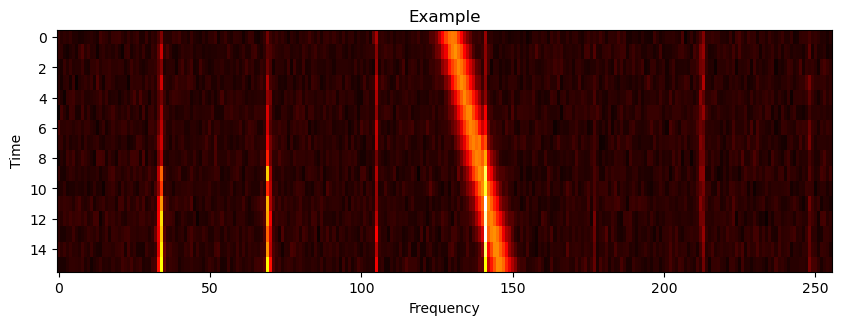

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
class_id = random.randint(0,100)
for i in range(class_id * num_samples_per_class, class_id * num_samples_per_class+5):
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(10,5))
    plt.title("Example")
    plt.xlabel("Frequency")
    plt.ylabel("Time")
    plt.imshow(injected[i, :, :], cmap='hot', aspect=5)

In [64]:
from tqdm import tqdm

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

data = np.expand_dims(normalize_data(injected), axis = -1)
print(data[0,:,:].max(), data[0,:,:].min())



100%|████████████████████████████████| 100000/100000 [00:09<00:00, 10703.73it/s]

1.0 0.0


In [65]:
features = autoencoder.encoder.predict(data)[0]

3125/3125 [==============================] - 7s 2ms/step


In [66]:
features.shape

(100000, 8)

In [68]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X = features, labels = labels[:,0])
print(score)

-0.11651354


In [67]:
score = silhouette_score(X = features[:20_000,:], labels = labels[:20_000,0])
print(score)

-0.0817249


# Disentanglement

In [94]:
def idealized(num=10_000):
    drift = 0
    snr = 20
    width = 10
    start = 256//2
    data = []
    labels = []
    for tag in range(4):
        label_vec = np.zeros(4)
        label_vec[tag] = 1
        for i in tqdm(range(num)):
            if tag == 0:
                drift = (-1)**(random.randint(0,2)) * 2 *random.random()
            elif tag == 1:
                snr = 50*random.random() +20
            elif tag == 2:
                width = 50*random.random() +20
            elif tag == 3:
                start = random.randint(50, 180)

            frame = stg.Frame(fchans=256*u.pixel,
                              tchans=16*u.pixel,
                              df=2.7939677238464355*u.Hz,
                              dt=18.253611008*u.s,
                              fch1=6095.214842353016*u.MHz)
            noise = frame.add_noise(x_mean=10, noise_type='chi2')
            frame.add_signal(stg.constant_path(
                                        f_start=frame.get_frequency(index=start),
                                       drift_rate=drift*u.Hz/u.s),
                                      stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
                                      stg.gaussian_f_profile(width=width*u.Hz),
                                      stg.constant_bp_profile(level=1))
            data.append(frame.data)
            labels.append(label_vec)
    data = np.array(data)
    labels = np.vstack(labels)
    return data, labels

In [95]:
idealized_signals, labels = idealized(num = 10_000)

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1182.75it/s]


100%|██████████████████████████████████| 40000/40000 [00:03<00:00, 10870.06it/s]


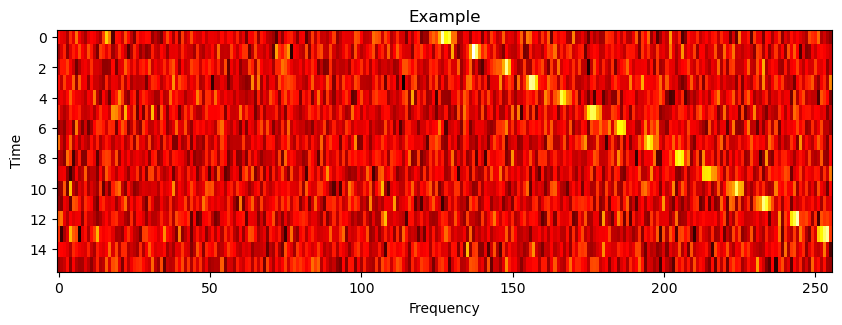

In [96]:
idealized_signals = np.expand_dims(normalize_data(idealized_signals), axis = -1)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(idealized_signals[0, :, :, 0], cmap='hot', aspect=5)

In [97]:
X = autoencoder.encoder.predict(idealized_signals)[0]

1250/1250 [==============================] - 3s 2ms/step


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

# Build Linear Classifier

In [104]:
linear = keras.Sequential(name="my_sequential")
linear.add(layers.Dense(8, activation="linear", name="layer1"))
linear.add(layers.Dense(4, activation="softmax", name="layer2"))


linear.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
linear.fit(X_train, y_train, epochs=150, batch_size=64, validation_split = 0.1, shuffle=True)


Epoch 1/150
377/377 [==============================] - 1s 2ms/step - loss: 1.0745 - accuracy: 0.6045 - val_loss: 0.6239 - val_accuracy: 0.8556
Epoch 2/150
377/377 [==============================] - 1s 2ms/step - loss: 0.4879 - accuracy: 0.8955 - val_loss: 0.3942 - val_accuracy: 0.9164
Epoch 3/150
377/377 [==============================] - 1s 2ms/step - loss: 0.3399 - accuracy: 0.9196 - val_loss: 0.3070 - val_accuracy: 0.9190
Epoch 4/150
377/377 [==============================] - 1s 2ms/step - loss: 0.2721 - accuracy: 0.9251 - val_loss: 0.2560 - val_accuracy: 0.9220
Epoch 5/150
377/377 [==============================] - 1s 2ms/step - loss: 0.2333 - accuracy: 0.9286 - val_loss: 0.2237 - val_accuracy: 0.9269
Epoch 6/150
377/377 [==============================] - 1s 2ms/step - loss: 0.2076 - accuracy: 0.9329 - val_loss: 0.2020 - val_accuracy: 0.9332
Epoch 7/150
377/377 [==============================] - 1s 2ms/step - loss: 0.1889 - accuracy: 0.9365 - val_loss: 0.1863 - val_accuracy: 0.9366

In [105]:
linear.evaluate(X_test, y_test)

413/413 [==============================] - 1s 2ms/step - loss: 0.0933 - accuracy: 0.9719


[0.09328942745923996, 0.9718939661979675]